# lesson-6

### Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import Prefilter_Items
from recommenders import MainRecommender

### Read data

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

### Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

### Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


### Prefilter items

In [11]:
n_items_train_before = data_train_matcher[ITEM_COL].nunique()
n_users_train_before = data_train_matcher[USER_COL].nunique()

prefilter_items = Prefilter_Items(drop_not_top_N=5000)
prefilter_items.fit(data_train_matcher)
data_train_matcher = prefilter_items.transform(data_train_matcher)

n_items_train_after = data_train_matcher[ITEM_COL].nunique()
n_users_train_after = data_train_matcher[USER_COL].nunique()

print('Decreased # items on train from {} to {}'.format(n_items_train_before, n_items_train_after))
print('Decreased # users on train from {} to {}'.format(n_users_train_before, n_users_train_after))

Decreased # items on train from 83685 to 5000
Decreased # users on train from 2498 to 2475


### Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (1216888, 12) Users: 1904 Items: 5000
val_matcher
Shape: (162611, 12) Users: 1904 Items: 26640
train_ranker
Shape: (162611, 12) Users: 1904 Items: 26640
val_ranker
Shape: (115539, 12) Users: 1904 Items: 23734


In [13]:
# Теперь warm-start по пользователям

### Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher, als_factors=400)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

### Eval recall of matching

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

In [15]:
ACTUAL_COL = 'actual'

In [16]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [17]:
# N = Neighbors
N_PREDICT = 50 

In [18]:
%%time
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['baseline_top_n'] = [recommender.recs_top_n(N=N_PREDICT)] * result_eval_matcher.shape[0]
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N_PREDICT))

Wall time: 2min 46s


#### Пускай, если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [19]:
def get_own_and_top_rec(own_rec, top_rec, N):
    return (own_rec + list(set(top_rec) - set(own_rec)))[:N]

In [20]:
result_eval_matcher['own_rec'] = result_eval_matcher['own_rec'].apply(lambda x: get_own_and_top_rec(x, result_eval_matcher['baseline_top_n'][0], N_PREDICT))

In [21]:
result_eval_matcher.head(8)

,user_id,actual,als_rec,own_rec,sim_item_rec,baseline_top_n
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1033142, 940631, 1041796, 1105433, 979707, 84...","[856942, 5577022, 9655212, 931136, 1124029, 80...","[891648, 981760, 9526411, 1052046, 842126, 655...","[1082185, 981760, 995242, 1127831, 840361, 109..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[904360, 878996, 849843, 866211, 5569230, 1055...","[13003092, 9911484, 5569792, 1084036, 1119051,...","[981760, 915586, 889731, 1068292, 962568, 8262...","[1082185, 981760, 995242, 1127831, 840361, 109..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[987724, 985999, 849843, 5591154, 1095100, 868...","[949836, 6944571, 6602729, 983316, 922561, 653...","[981760, 859010, 9832070, 962568, 1038985, 819...","[1082185, 981760, 995242, 1127831, 840361, 109..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[951590, 1065593, 1091365, 1133018, 1003421, 8...","[8181377, 1116578, 981660, 1105433, 969932, 55...","[981760, 1005186, 889731, 1101956, 982790, 111...","[1082185, 981760, 995242, 1127831, 840361, 109..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[862799, 1056005, 1035880, 856772, 1139471, 10...","[1056005, 862799, 1018588, 995055, 1090017, 10...","[916993, 918018, 1056005, 826249, 862349, 8446...","[1082185, 981760, 995242, 1127831, 840361, 109..."
5,13,"[6544236, 822407, 908317, 1056775, 1066289, 11...","[1110292, 951590, 1022097, 8090521, 1136257, 9...","[893802, 1038985, 862070, 1042942, 898466, 101...","[981760, 6533765, 1053063, 1038985, 971922, 11...","[1082185, 981760, 995242, 1127831, 840361, 109..."
6,14,"[917277, 981760, 878234, 925514, 986394, 10220...","[999270, 1103629, 844165, 5568378, 995242, 107...","[13876901, 1056651, 904774, 861615, 861486, 93...","[6533765, 826249, 1138443, 985999, 901776, 863...","[1082185, 981760, 995242, 1127831, 840361, 109..."
7,15,"[996016, 1014509, 1044404, 1087353, 976199, 10...","[834484, 1053530, 1042616, 945779, 863632, 895...","[920002, 910439, 1053530, 835595, 1034956, 957...","[981760, 915586, 1019142, 1098248, 1103752, 10...","[1082185, 981760, 995242, 1127831, 840361, 109..."


In [22]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [23]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [24]:
TOPK_RECALL = 50

In [25]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('als_rec', 0.10763161729186223),
 ('own_rec', 0.09025249554302363),
 ('baseline_top_n', 0.08653941564773591),
 ('sim_item_rec', 0.07862520018121512)]

### Precision@5 of matching

In [26]:
TOPK_PRECISION = 5

In [27]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.25787815126050173),
 ('baseline_top_n', 0.20031512605041774),
 ('als_rec', 0.16628151260504007),
 ('sim_item_rec', 0.09527310924369715)]

#### Дают ли own recommendtions + top-popular лучший recall?

НЕТ

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [28]:
%%time

K = [20, 50, 100, 200, 500]

als_rec_at_k  = [(result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=k)), k) for k in K]

als_recall_at_k = [(np.array([recall_at_k(rec[0][i], result_eval_matcher[ACTUAL_COL][i], k=rec[1]) for i in result_eval_matcher.index]).mean(), rec[1]) for rec in als_rec_at_k]

als_recall_at_k

Wall time: 3min


[(0.05622235389080182, 20),
 (0.10763161729186196, 50),
 (0.16699475596610544, 100),
 (0.23879500939121565, 200),
 (0.32716085341540724, 500)]

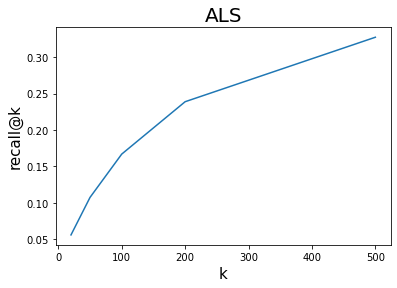

In [29]:
plt.plot(K, list(map(lambda x: x[0], als_recall_at_k)))
plt.title('ALS', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.ylabel('recall@k', fontsize=15)
plt.show()

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

recall@0 = 0, recall@5001 = 1

Чем больше k, чем больше потенциальных товаров (кандидатов) мы отбираем, тем модель второго уровня порекомендует точнее, но это будет дольше, так как количетво данных возрастёт до n * k, где n, это количетсво пользователей для которых мы рекомендуем, с учётом горячего старта 1915 пользователей.

Число k подбирается с учётом возможностей по мощности и времени ожидания.

Оптимальное число k находится на перегибе графика recall@k(k), там где стремтильный рост recall@k снижается. В нашем случае за перегиб можно взять точку k=200.

In [30]:
N_PREDICT = 200

### Подготовка данных для трейна

In [31]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [32]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

In [33]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1004906, 1082185, 1056509, 871756, 897954, 86..."
1,2021,"[1070702, 950935, 1119454, 1019142, 907014, 82..."


In [34]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = ITEM_COL

In [35]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [36]:
df_match_candidates.head(8)

,user_id,item_id
0,2070,1004906
0,2070,1082185
0,2070,1056509
0,2070,871756
0,2070,897954
0,2070,861279
0,2070,1005186
0,2070,1074754


### Check warm start

In [37]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (380800, 2) Users: 1904 Items: 5000


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1

In [38]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL, 'quantity']].copy()
df_ranker_train.rename(columns={'quantity': 'target'}, inplace=True)
df_ranker_train = df_ranker_train.groupby([USER_COL, ITEM_COL]).count().reset_index()
df_ranker_train['target'] = df_ranker_train['target'].astype(bool).astype(int)
df_ranker_train.head(5)

,user_id,item_id,target
0,1,820165,1
1,1,829323,1
2,1,829563,1
3,1,830156,1
4,1,832990,1


In [39]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
df_ranker_train['target'].fillna(0, inplace= True)
df_ranker_train.head(5)

,user_id,item_id,target
0,2070,1004906,0.0
1,2070,1082185,1.0
2,2070,1056509,0.0
3,2070,871756,0.0
4,2070,897954,0.0


In [40]:
df_ranker_train.target.value_counts()

0.0    350324
1.0     30476
Name: target, dtype: int64

In [41]:
df_ranker_train['target'].mean()

0.08003151260504202

#### Сильный дизбаланс классов!!!

In [42]:
df_ranker_train.head(9)

,user_id,item_id,target
0,2070,1004906,0.0
1,2070,1082185,1.0
2,2070,1056509,0.0
3,2070,871756,0.0
4,2070,897954,0.0
5,2070,861279,0.0
6,2070,1005186,0.0
7,2070,1074754,0.0
8,2070,1081177,0.0


### Подготавливаем фичи для обучения модели

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

In [43]:
data_train_ranker.head(5) #6 недель

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


### user

In [44]:
df_ranker_train[~df_ranker_train['user_id'].isin(user_features.user_id)].shape[0]

228800

In [45]:
df_ranker_train['user_id'].shape[0]

380800

In [46]:
df_ranker_train[~df_ranker_train['user_id'].isin(user_features.user_id)].shape[0] / df_ranker_train['user_id'].shape[0] * 100

60.08403361344538

Отсутствуют данные о 60% пользователей, по этому мы не будем использовать user_features который нам дан, но сделаем небольшой свой на основе имеющихся данных из data.

Средний чек

In [47]:
average_check = (data_train_ranker.groupby([USER_COL])['sales_value'].sum() 
                                  / data_train_ranker.groupby([USER_COL])['basket_id'].nunique()).reset_index()

average_check.columns=[USER_COL, 'average_check']

user_features = average_check.copy()

Количество покупок в месяц

In [48]:
user_per_month = (data_train_ranker.groupby([USER_COL])['basket_id'].nunique() 
                                                  / ((VAL_MATCHER_WEEKS*7) / (365/12))).reset_index()

user_per_month.columns=[USER_COL, 'user_per_month']

user_features = user_features.merge(user_per_month, on=USER_COL, how='left')

In [49]:
user_features.head(2)

,user_id,average_check,user_per_month
0,1,48.825714,5.069444
1,6,20.562500,11.587302


### item

In [50]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


Количество покупок в неделю

In [51]:
item_per_week = (data_train_ranker.groupby([ITEM_COL])['quantity'].sum() / 6).reset_index()

item_per_week.columns=[ITEM_COL, 'item_per_week']

item_features = item_features.merge(item_per_week, on=ITEM_COL, how='left')

item_features.item_per_week.fillna(0, inplace=True)

Цена

In [52]:
data_price = data[data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS)] 

data_price['price'] = data_price['sales_value'] / data_price['quantity']

price = (data_price.groupby([ITEM_COL])['price'].first()).reset_index()

item_features = item_features.merge(price, on=ITEM_COL, how='left')

C:\Users\D9F8~1\AppData\Local\Temp/ipykernel_3760/208773345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_price['price'] = data_price['sales_value'] / data_price['quantity']


In [53]:
item_features.price.fillna(item_features.price.median(), inplace=True)

In [54]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.0,0.99


### user-item

In [55]:
df_ranker_train = df_ranker_train.merge(item_features, on=ITEM_COL, how='left')
df_ranker_train = df_ranker_train.merge(user_features, on=USER_COL, how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price,average_check,user_per_month
0,2070,1004906,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,37.333333,1.39,14.355581,31.140873
1,2070,1082185,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,302.333333,1.21,14.355581,31.140873


In [56]:
df_ranker_train.isna().sum().sum()

0

Пропусков нету, это отлично!

In [57]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [58]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'item_per_week',
 'price',
 'average_check',
 'user_per_month']

### Обучение модели ранжирования

In [59]:
%%time

lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

D:\anakonda\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anakonda\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Константин\AppData\Roaming\Python\Python38\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Wall time: 11.8 s


In [60]:
df_ranker_predict = df_ranker_train.copy()

In [61]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [62]:
df_ranker_predict.head(9)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price,average_check,user_per_month,proba_item_purchase
0,2070,1004906,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,37.333333,1.39,14.355581,31.140873,0.332876
1,2070,1082185,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,302.333333,1.21,14.355581,31.140873,0.685154
2,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,22.500000,2.09,14.355581,31.140873,0.351989
3,2070,871756,0.0,317,GROCERY,National,SALD DRSNG/SNDWCH SPRD,SEMI-SOLID SALAD DRESSING MAY,32 OZ,17.166667,2.00,14.355581,31.140873,0.302239
4,2070,897954,0.0,4303,MEAT,National,CHICKEN,CHICKEN BREAST BONELESS,,12.333333,4.13,14.355581,31.140873,0.173262
5,2070,861279,0.0,1322,GROCERY,National,CONDIMENTS/SAUCES,STEAK & WORCHESTER SAUCE,10 OZ,5.666667,4.19,14.355581,31.140873,0.104410
6,2070,1005186,0.0,2,SALAD BAR,National,SALAD BAR,SALAD BAR FRESH FRUIT,,59.166667,1.29,14.355581,31.140873,0.430334
7,2070,1074754,0.0,1075,GROCERY,National,COOKIES/CONES,SANDWICH COOKIES,18 OZ,5.833333,2.97,14.355581,31.140873,0.142173
8,2070,1081177,0.0,2,PRODUCE,National,TOMATOES,TOMATOES VINE RIPE BULK,15 LB,19.833333,1.00,14.355581,31.140873,0.219750


In [63]:
df_ranker_predict.shape

(380800, 14)

In [64]:
df_ranker_predict.loc[df_ranker_predict[USER_COL]==2070].sort_values('proba_item_purchase', ascending=False)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price,average_check,user_per_month,proba_item_purchase
1,2070,1082185,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,302.333333,1.21,14.355581,31.140873,0.685154
113,2070,995242,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,188.833333,1.99,14.355581,31.140873,0.607152
102,2070,989101,1.0,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,GAL,20.000000,0.69,14.355581,31.140873,0.559756
41,2070,834117,1.0,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,10.833333,3.99,14.355581,31.140873,0.532696
19,2070,962568,1.0,2,PRODUCE,National,VEGETABLES - ALL OTHERS,CELERY,,68.833333,1.29,14.355581,31.140873,0.526068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2070,1046545,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,0.000000,2.99,14.355581,31.140873,0.001926
37,2070,9527290,0.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,0.000000,1.50,14.355581,31.140873,0.001778
106,2070,857215,0.0,3020,MEAT,National,PORK,LOIN - CHOPS BONELESS,,0.000000,16.08,14.355581,31.140873,0.001748
189,2070,906923,0.0,2,PRODUCE,National,GRAPES,GRAPES WHITE,16 LB,0.000000,4.16,14.355581,31.140873,0.001659


- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

### Evaluation on test dataset

In [65]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


### Eval matching on test dataset

In [66]:
%%time
result_eval_ranker['als_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 36.4 s


In [67]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('als_rec', 0.12636554621848656)]

### Eval re-ranked matched result on test dataset

In [68]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [69]:
result_eval_ranker['reranked_als_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [70]:
result_eval_ranker

,user_id,actual,als_rec,reranked_als_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 940631, 1041796, 1105433, 979707, 84...","[1082185, 995242, 872137, 840361, 914190]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[904360, 878996, 849843, 866211, 5569230, 1055...","[1082185, 1098844, 962568, 981760, 862349]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[987724, 985999, 849843, 5591154, 1095100, 868...","[1126899, 1058997, 849843, 1013321, 1122358]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[951590, 1065593, 1091365, 1133018, 1003421, 8...","[1082185, 1106523, 833715, 1003421, 1005186]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[862799, 1056005, 1035880, 856772, 1139471, 10...","[1029743, 1082185, 908531, 849843, 883404]"
...,...,...,...,...
1899,2496,[6534178],"[911812, 914190, 5591170, 979707, 1106523, 108...","[1082185, 1106523, 1041796, 899624, 5569230]"
1900,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[5569230, 1042697, 995876, 1034176, 841220, 89...","[995242, 899624, 883404, 995785, 962568]"
1901,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[893501, 824555, 846550, 835576, 923673, 92536...","[1070820, 1053690, 961554, 13841744, 862349]"
1902,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[965766, 929668, 930917, 952163, 938700, 95701...","[1070820, 6534178, 883404, 6533889, 899624]"


In [71]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_als_rec', 0.31008403361344483)
('als_rec', 0.12636554621848656)


- Вырос ли precision@5 при использовании двухуровневой модели?

ДА

#### Памятка для курсовой

#### Также нужно будет проверить данные на выбросы, перевести категориальные признаки в вещественные где это возможно, побороть дизбаланс классов, провести отбор признаков, попробывать другие модели 2-го уровня(сводная таблица как для моделей 1-го уровня) и подобрать гиперпараметры для модели 2-го уровня!!! (Написать везде коментарии к коду и расписать тз)